# Distribution

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
dxs = [0.01, 0.05, 0.10, 0.50, 1.00]
densities = [0.05, 0.30, 0.50, 1.00]

In [6]:
def read_values(density, dx):
    """
    paramaters
    ----------
    density : float
        Density of the system
    dx : displacement max

    Returns
    -------
    parameters : dict
        Dictionary containing the parameters of the system
    results : dict
        Dictionary containing the tries, acceptances, overlaps and final energy
    all_positions : list
        List of the positions of the particles
    """
    parameters = {}
    results = {}
    all_positions = []
    for i in range(10):
        with open('./data/density={:.2f}/dx={:.2f}sigma/run{}.xyz'.format(density,dx,i), 'r') as file:
            lines = file.readlines()

        #Parameters are equal for each realization
        if i == 0:
            parameters["N"] = int(lines[0].split('=')[1].strip())
            parameters["N_steps"] = int(lines[1].split('=')[1].strip())
            parameters["box_x"] = float(lines[2].split('=')[1].strip())
            parameters["box_y"] = float(lines[3].split('=')[1].strip())
            parameters["box_z"] = float(lines[4].split('=')[1].strip())
            parameters["temperature"] = float(lines[5].split('=')[1].strip())
            parameters["delta_x"] = float(lines[6].split('=')[1].strip())
            parameters["myseed"] = int(lines[7].split('=')[1].strip())
            parameters["sigma"] = float(lines[8].split('=')[1].strip())
            parameters["model"] = int(lines[9].split('=')[1].strip())
            parameters["density"] = float(lines[13].split('=')[1].strip())
        
            results["tries"] = [int(lines[10].split('=')[1].strip())]
            results["accepted"] = [int(lines[11].split('=')[1].strip())]
            results["overlap"] = [int(lines[12].split('=')[1].strip())]
            results["E"] = [float(lines[14].split('=')[1].strip())]

        else:
            results["tries"].append(int(lines[10].split('=')[1].strip()))
            results["accepted"].append(int(lines[11].split('=')[1].strip()))
            results["overlap"].append(int(lines[12].split('=')[1].strip()))
            results["E"].append(float(lines[14].split('=')[1].strip()))
        # Parse the positions
        positions = []
        for line in lines[16:]:
            pos = list(map(float, line.split()[1:]))
            positions.append(pos)
        all_positions.append(positions)
    return parameters, results, all_positions


In [7]:
param, res, all_pos = read_values(0.05,0.01)

#### Density plots

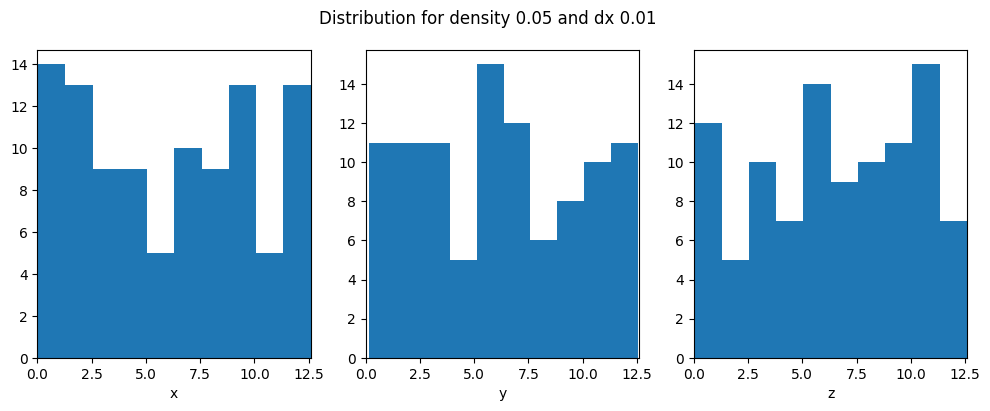

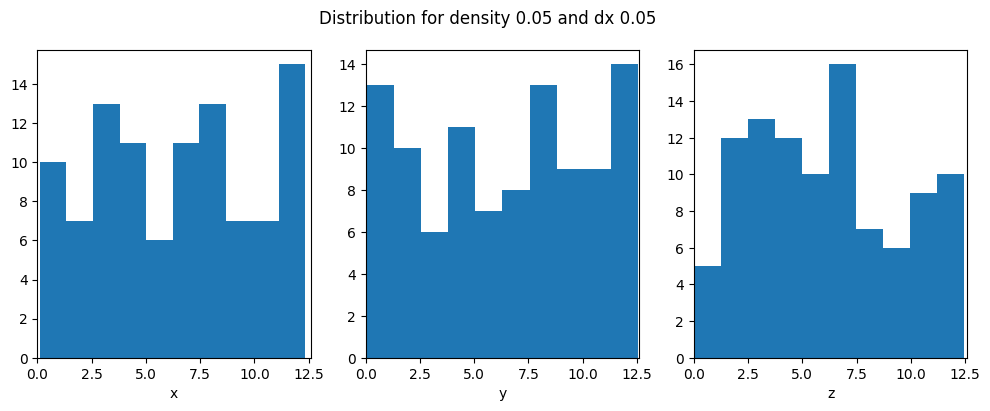

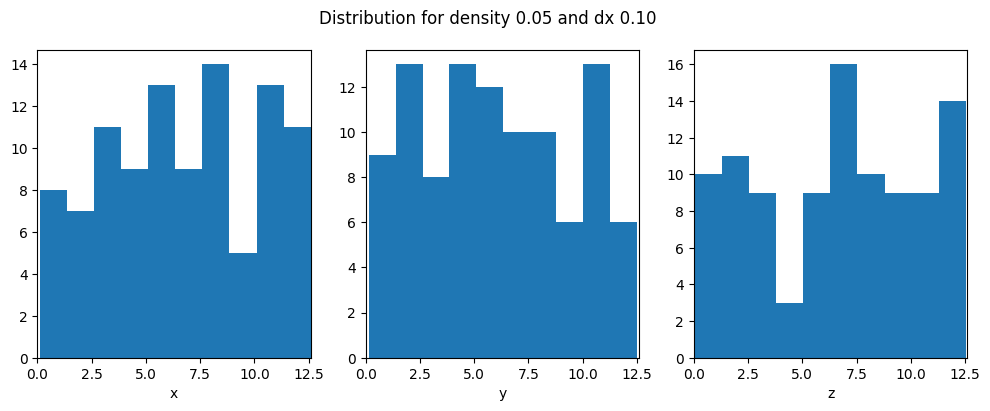

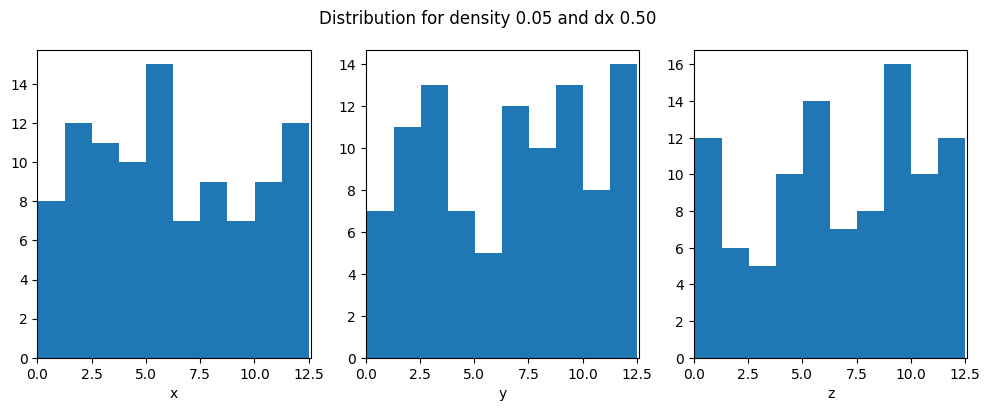

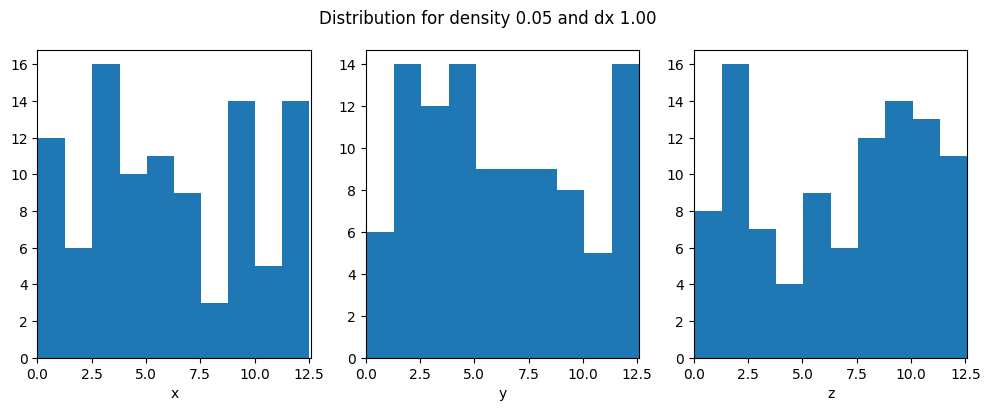

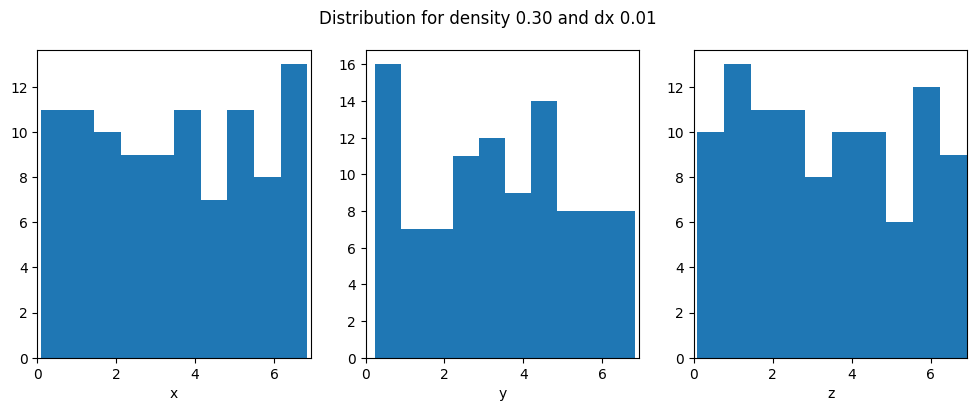

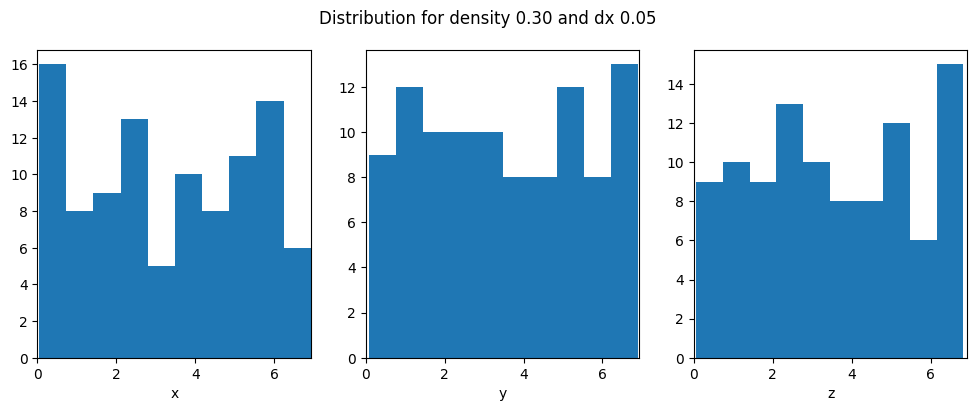

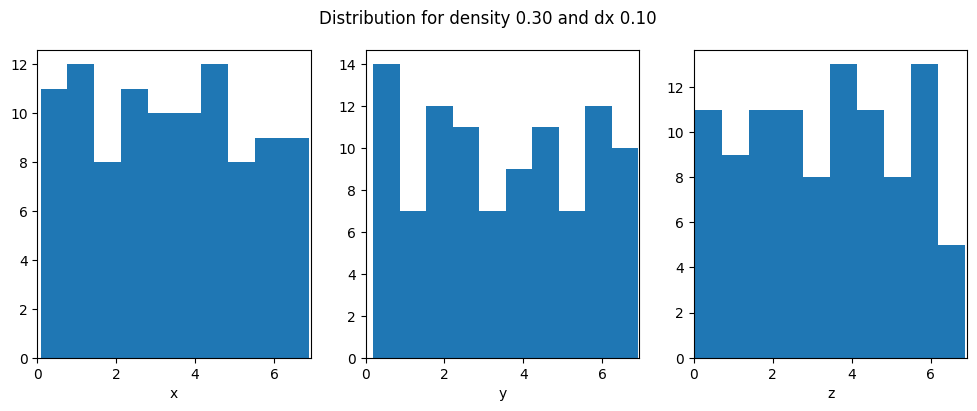

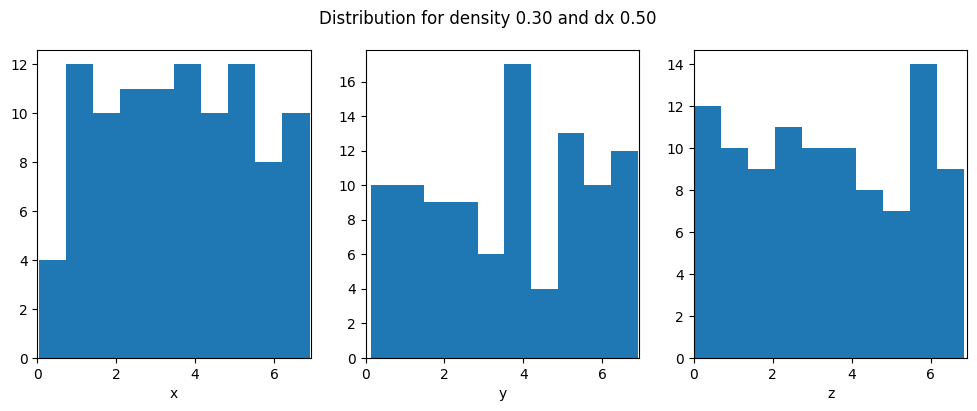

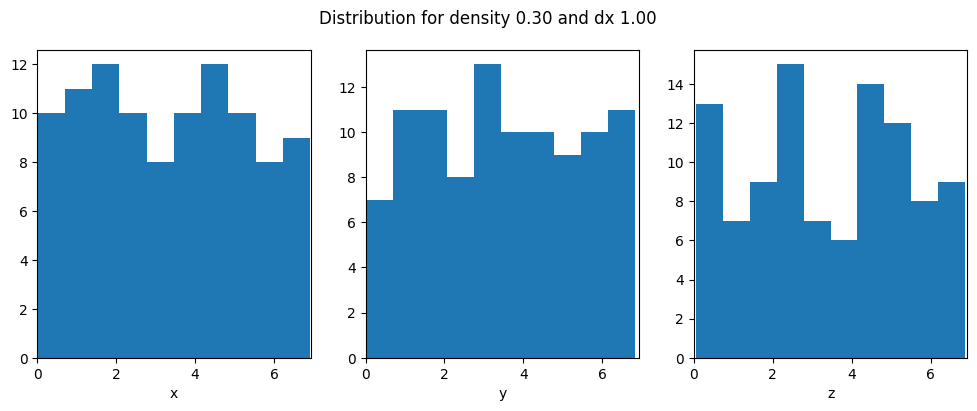

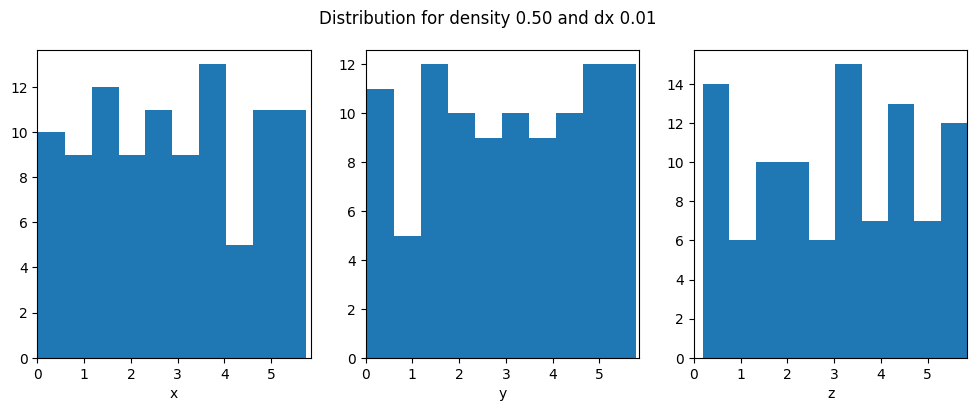

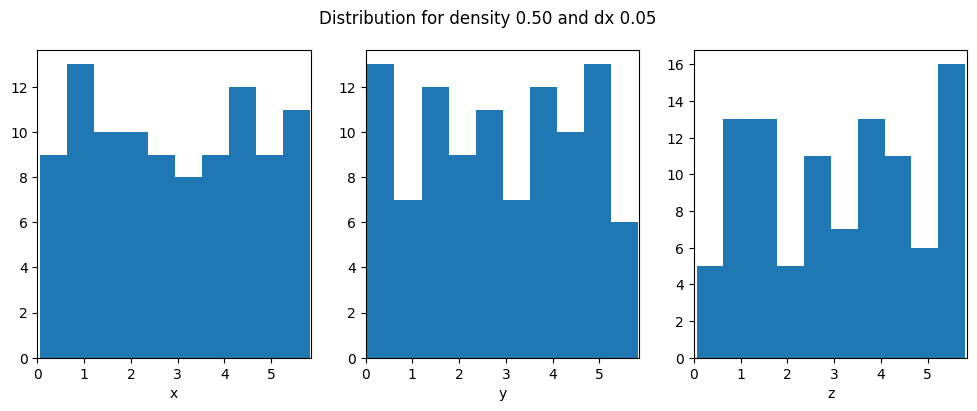

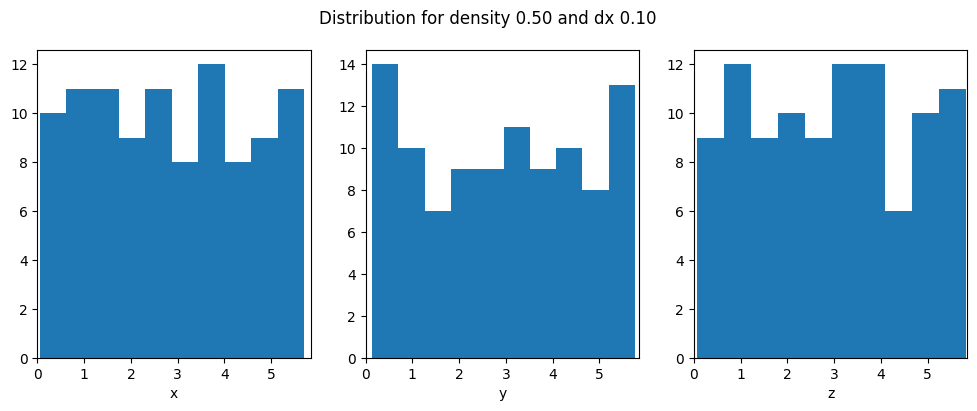

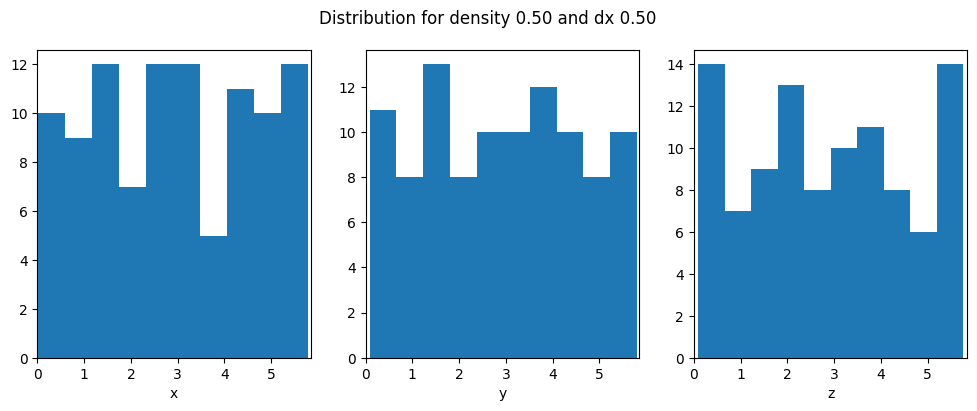

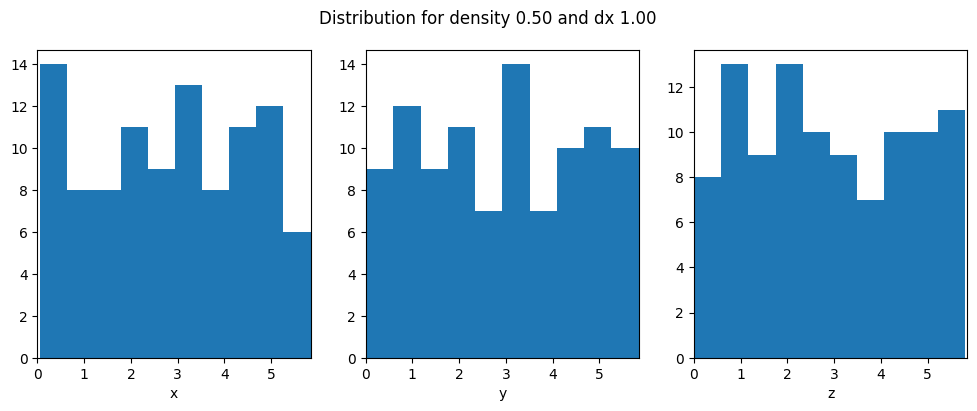

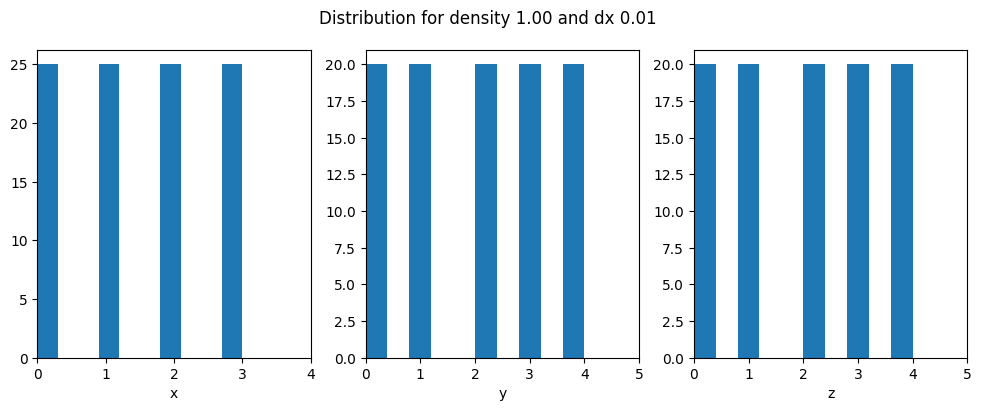

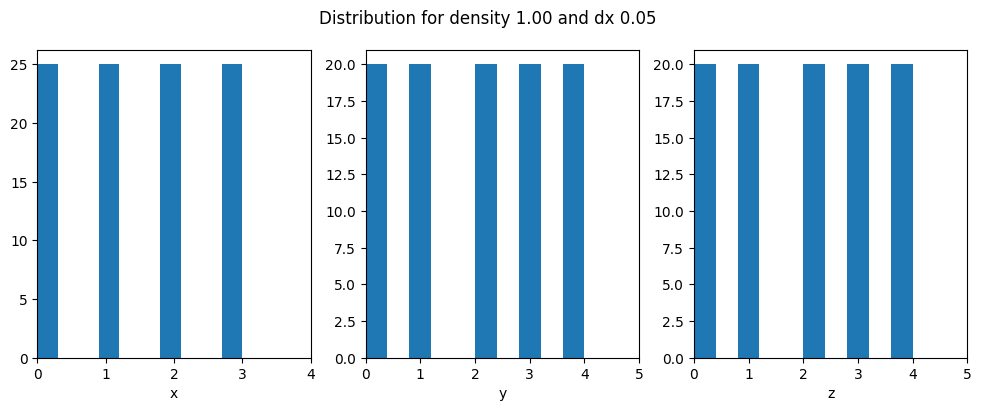

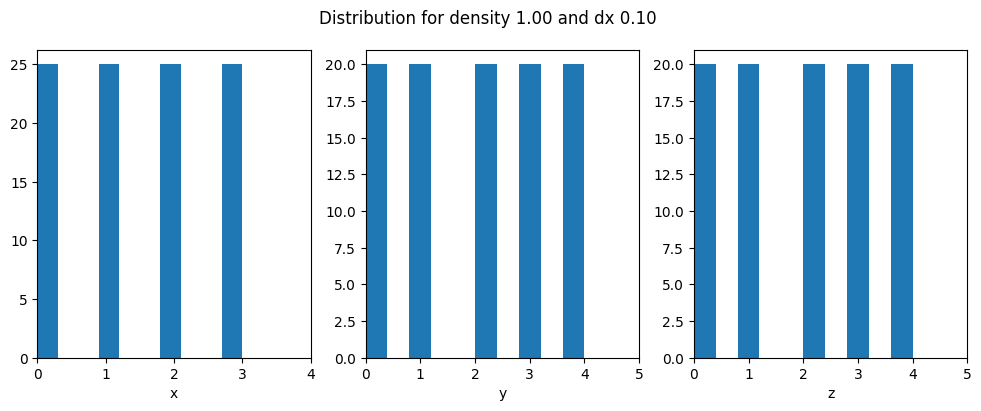

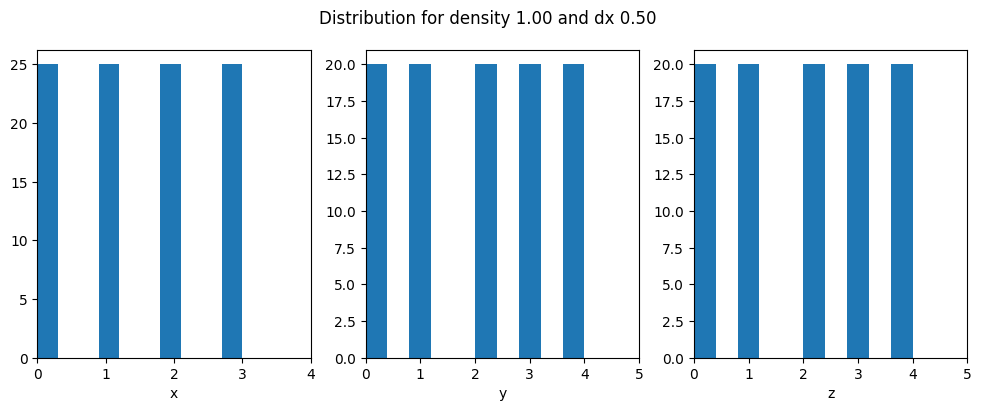

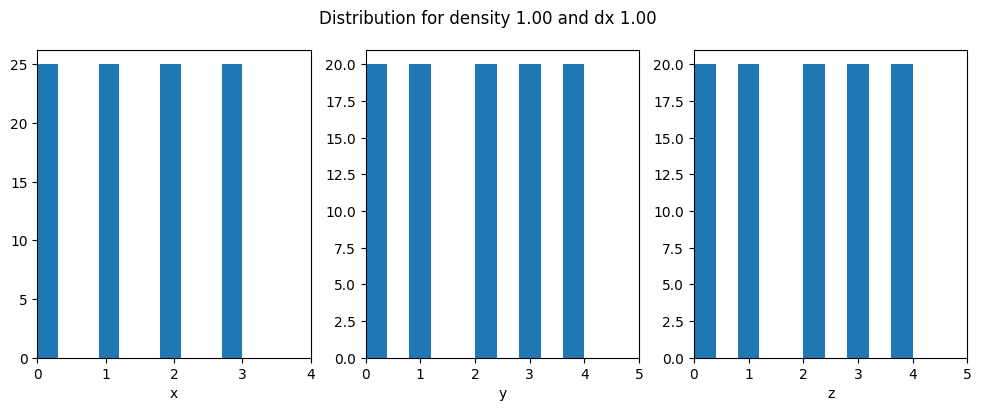

In [8]:
from random import randint
def plot_densities():
    for density in densities:
        for dx in dxs:
            r_int = randint(0,9) #Plot one random realization per density and dx
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            params, res, all_pos = read_values(density,dx)
            for j in range(3):
                i_ax_vals = [pos[j] for pos in all_pos[r_int]]
                axes[j].hist(i_ax_vals)#, bins=50, density=True)
                axes[j].set_xlim([0, params[f"box_{'xyz'[j]}"]])
            axes[0].set_xlabel('x')
            axes[1].set_xlabel('y')
            axes[2].set_xlabel('z')
            fig.suptitle("Distribution for density {:.2f} and dx {:.2f}".format(density,dx))

plot_densities()

## Acceptance ratio

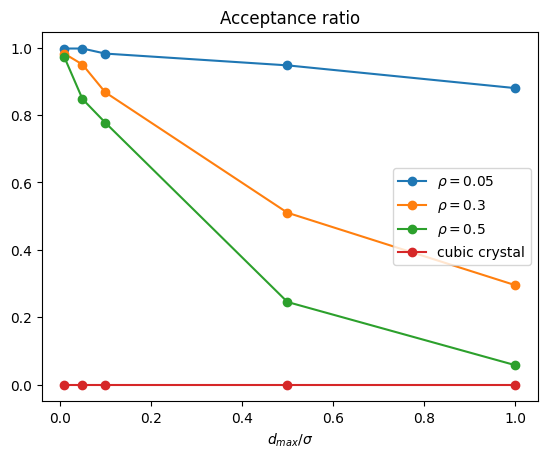

In [9]:
def calculate_acceptance_ratios():
    acceptance_ratios = {} #Fill with values
    for dens in densities:
        acceptance_ratios[str(dens)] = []
        for dx in dxs:
            _, temp_results, _ = read_values(dens, dx)
            temp_acceptance_ratio = np.mean([temp_results["accepted"][i]/temp_results["tries"][i] for i in range(len(temp_results))])
            acceptance_ratios[str(dens)].append(temp_acceptance_ratio)
    return acceptance_ratios

acceptance_ratios = calculate_acceptance_ratios()
for key, val in acceptance_ratios.items():
    if key == "1.0":
        plt.plot(dxs, val, "o-", label=r"cubic crystal")
    else:
        plt.plot(dxs, val, "o-", label=r"$\rho=$" + key)
plt.xlabel(r"$d_{max}/\sigma$")
# plt.xticks([r"$\sigma$", 0])
plt.title("Acceptance ratio")
plt.legend()

The results are done over an average of 10 realizations per data point.

There is a trend that an increase in density leads to decrease in acceptance rate, which could be explained by the lack of space to move around in, increasing the probability for an overlap.

There is also a trend that an increase in $d_{max}$ leads to a decrease in acceptance ratio. This is probably due to the fact that if a sphere can only move $0.1*\sigma$ in each direction, it maximum needs some fraction of the sphere volume of free space to move. While for larger displacements, e.g. on the scale of $\sigma$, you could end up needing free space on the size of a sphere, to be allowed to do the move. This would also decrease the acceptance ratio when the volume decreases, since the probbability of finding free space decreases for the spheres.

For $\rho = 1.0$, the system struggles to initialize the particles in a random manner after around 70 particles, so I've avoided doing this in a random manner

To explain the simple cubic crystal case, one has to understand that even though the spheres only take up $\frac{4 \pi r^3}{3} = 52.4$ of free space, which is $52.4\%$ of the total free space, they would lie tightly packed and unable to move, since there diameter is $\sigma = 1$, which only allows 100 particles in a total free space of a 100 when packed linearly in xyz directions. 
In other words, with one side in the lattice being $a = \sigma$, you can maximum have a $4*5*5 = 100$ crystals in the system. When adding the fact that each crystal has a packing factor of 1, you get a total of 100 atoms in the simple cubic grid.


In [10]:

for dens in densities:
    for dx in dxs:
        params, results, all_pos = read_values(dens, dx)

        run_num = 0
        for pos_vec in all_pos:
            for i in range(len(pos_vec)):
                for j in range(i+1, len(pos_vec)):
                    dist = np.sqrt(sum([(pos_vec[i][k] - pos_vec[j][k])**2 for k in range(3)]))
                    if dist < params["sigma"]:
                        print("Overlap")
                        print(f"density: {dens}, dx: {dx}, run: {run_num}")
                        print(f"particle {i}: {pos_vec[i]}")
                        print(f"particle {j}: {pos_vec[j]}")
                        print(dist)
                        print(params["sigma"])
                        print()
            run_num += 1

Overlap
density: 0.05, dx: 0.01, run: 9
particle 11: [8.2, 4.74, 5.53]
particle 63: [7.52, 5.47, 5.54]
0.9976973488989529
1.0

Overlap
density: 0.05, dx: 0.1, run: 2
particle 84: [4.52, 9.26, 4.93]
particle 90: [4.17, 9.62, 5.79]
0.9958413528268446
1.0

Overlap
density: 0.05, dx: 0.5, run: 7
particle 13: [5.26, 5.87, 1.73]
particle 27: [5.24, 4.89, 1.92]
0.9984487968844475
1.0

Overlap
density: 0.3, dx: 0.01, run: 2
particle 22: [4.2, 6.67, 1.92]
particle 58: [5.16, 6.78, 1.67]
0.9980981915623333
1.0

Overlap
density: 0.3, dx: 0.01, run: 3
particle 29: [6.33, 5.79, 3.03]
particle 47: [6.01, 6.45, 2.36]
0.9934284070832685
1.0

Overlap
density: 0.3, dx: 0.01, run: 5
particle 17: [5.25, 3.72, 5.0]
particle 25: [5.44, 4.7, 4.98]
0.9984487968844471
1.0

Overlap
density: 0.3, dx: 0.01, run: 7
particle 43: [1.36, 2.25, 4.03]
particle 92: [1.17, 1.84, 4.92]
0.9981482855768473
1.0

Overlap
density: 0.3, dx: 0.01, run: 9
particle 43: [2.45, 0.21, 6.86]
particle 85: [2.34, 0.36, 5.88]
0.997496867

In [11]:
max_overlap = 1
n_overlaps = 0
for dens in densities:
    for dx in dxs:
        params, results, all_pos = read_values(dens, dx)

        run_num = 0
        for pos_vec in all_pos:
            for i in range(len(pos_vec)):
                for j in range(i+1, len(pos_vec)):
                    dist = np.sqrt(sum([(pos_vec[i][k] - pos_vec[j][k])**2 for k in range(3)]))
                    if dist < params["sigma"]:
                        print("Overlap")
                        print(f"density: {dens}, dx: {dx}, run: {run_num}")
                        print(f"particle {i}: {pos_vec[i]}")
                        print(f"particle {j}: {pos_vec[j]}")
                        print(dist)
                        print()
                        n_overlaps += 1
                        if dist < max_overlap:
                            max_overlap = dist
            run_num += 1

print("Max overlap: ", max_overlap)
print("Number of overlaps: ", n_overlaps)

Overlap
density: 0.05, dx: 0.01, run: 9
particle 11: [8.2, 4.74, 5.53]
particle 63: [7.52, 5.47, 5.54]
0.9976973488989529

Overlap
density: 0.05, dx: 0.1, run: 2
particle 84: [4.52, 9.26, 4.93]
particle 90: [4.17, 9.62, 5.79]
0.9958413528268446

Overlap
density: 0.05, dx: 0.5, run: 7
particle 13: [5.26, 5.87, 1.73]
particle 27: [5.24, 4.89, 1.92]
0.9984487968844475

Overlap
density: 0.3, dx: 0.01, run: 2
particle 22: [4.2, 6.67, 1.92]
particle 58: [5.16, 6.78, 1.67]
0.9980981915623333

Overlap
density: 0.3, dx: 0.01, run: 3
particle 29: [6.33, 5.79, 3.03]
particle 47: [6.01, 6.45, 2.36]
0.9934284070832685

Overlap
density: 0.3, dx: 0.01, run: 5
particle 17: [5.25, 3.72, 5.0]
particle 25: [5.44, 4.7, 4.98]
0.9984487968844471

Overlap
density: 0.3, dx: 0.01, run: 7
particle 43: [1.36, 2.25, 4.03]
particle 92: [1.17, 1.84, 4.92]
0.9981482855768473

Overlap
density: 0.3, dx: 0.01, run: 9
particle 43: [2.45, 0.21, 6.86]
particle 85: [2.34, 0.36, 5.88]
0.9974968671630006

Overlap
density: 0.

## $P/\rho$ - plane

#### Help func

In [14]:
def read_values_LJ(density, dx, T):
    """
    paramaters
    ----------
    density : density of the system
    dx : displacement max
    T : temperature

    Returns
    -------
    parameters : dict
        Dictionary containing the parameters of the system
    results : dict
        Dictionary containing the tries, acceptances, overlaps and final energy
    all_positions : list
        List of the positions of the particles
    """
    parameters = {}
    results = {}
    all_positions = []
    for i in range(5):
        with open('./data/LJ/T={:.1f}/density={:.2f}/dx={:.2f}sigma/run{}.xyz'.format(T, density,dx,i), 'r') as file:
            lines = file.readlines()

        #Parameters are equal for each realization
        if i == 0:
            parameters["N"] = int(lines[0].split('=')[1].strip())
            parameters["N_steps"] = int(lines[1].split('=')[1].strip())
            parameters["box_x"] = float(lines[2].split('=')[1].strip())
            parameters["box_y"] = float(lines[3].split('=')[1].strip())
            parameters["box_z"] = float(lines[4].split('=')[1].strip())
            parameters["temperature"] = float(lines[5].split('=')[1].strip())
            parameters["delta_x"] = float(lines[6].split('=')[1].strip())
            parameters["myseed"] = int(lines[7].split('=')[1].strip())
            parameters["sigma"] = float(lines[8].split('=')[1].strip())
            parameters["model"] = int(lines[9].split('=')[1].strip())
            parameters["density"] = float(lines[13].split('=')[1].strip())
        
            results["tries"] = [int(lines[10].split('=')[1].strip())]
            results["accepted"] = [int(lines[11].split('=')[1].strip())]
            results["overlap"] = [int(lines[12].split('=')[1].strip())]
            results["E"] = [float(lines[14].split('=')[1].strip())]
            results["P"] = [float(lines[15].split('=')[1].strip())]

        else:
            results["tries"].append(int(lines[10].split('=')[1].strip()))
            results["accepted"].append(int(lines[11].split('=')[1].strip()))
            results["overlap"].append(int(lines[12].split('=')[1].strip()))
            results["E"].append(float(lines[14].split('=')[1].strip()))
            results["P"] = [float(lines[14].split('=')[1].strip())]
        # Parse the positions
        positions = []
        for line in lines[17:]:
            pos = list(map(float, line.split()[1:]))
            positions.append(pos)
        all_positions.append(positions)
    return parameters, results, all_positions


### My run

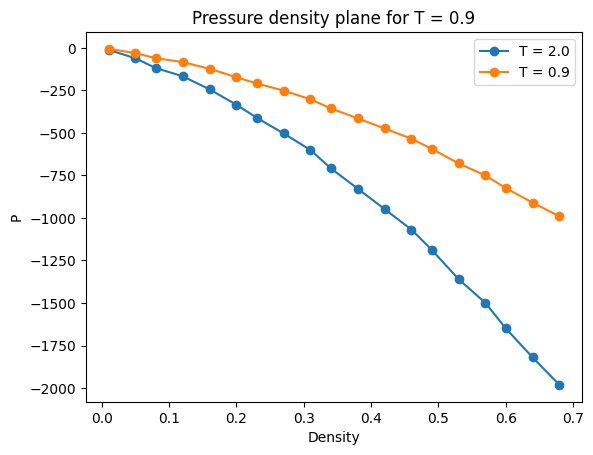

In [47]:
def plot_P_densities(T):
    densities = np.around(np.linspace(0.01, 0.9, 25), decimals=2)
    dx = 1.0
    Values = {"density": [], "P": []}
    for density in densities:
        if density < 0.71: #Initialization problem above that
            _, results, _ = read_values_LJ(density, dx, T)
            Values["density"].append(density)
            Values["P"].append(results["P"])

    plt.plot(Values["density"], Values["P"], "o-", label=(r"T = {:.1f}".format(T)))
    plt.xlabel(r"Density")
    plt.ylabel("P")
    plt.title("Pressure density plane for T = {:.1f}".format(T))
    plt.legend()
plot_P_densities(2.0)
plot_P_densities(0.9)

### Theoretical

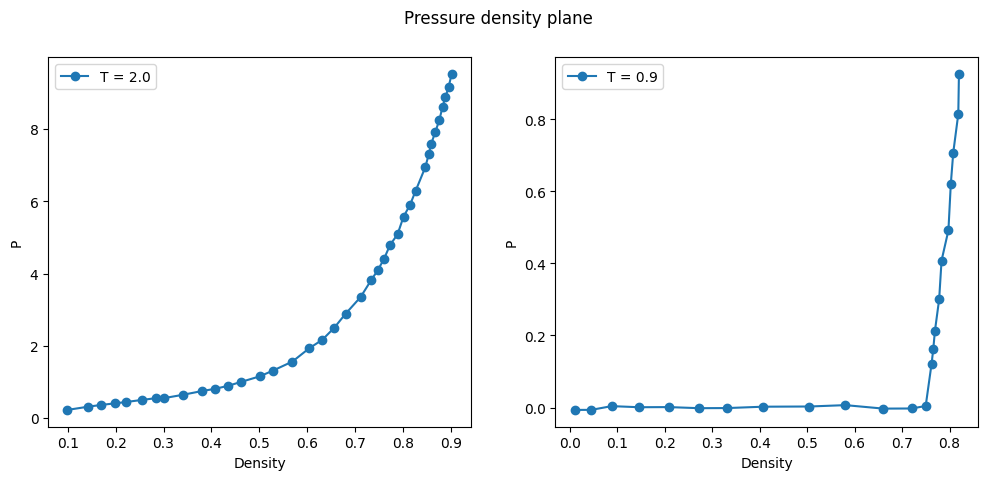

In [48]:
def plot_theoretical():
    file_T2 = open("LJ_T2.dat", "r")
    file_T09 = open("LJ_T09.txt", "r")
    #T = 2.0
    lines_T2 = file_T2.readlines()
    densities_T2 = []
    P_T2 = []
    for line in lines_T2:
        if line != "\n":
            density, P = line.split(" ")
            densities_T2.append(float(density))
            P_T2.append(float(P))

    #T = 0.9
    lines_T09 = file_T09.readlines()
    densities_T09 = []
    P_T09 = []
    for line in lines_T09:
        if line != "\n":
            density, P = line.split(" ")
            densities_T09.append(float(density))
            P_T09.append(float(P))

    fig, axes = plt.subplots(1,2)
    axes[0].plot(densities_T2, P_T2, "-o", label="T = 2.0")
    axes[1].plot(densities_T09, P_T09, "-o", label="T = 0.9")
    for ax in axes:
        ax.set_xlabel("Density")
        ax.set_ylabel("P")
        ax.legend()
    fig.set_figwidth(12)
    fig.suptitle("Pressure density plane")

plot_theoretical()